Mount Drive dan Pindah ke Folder Proyek

In [1]:
from google.colab import drive
import os

drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/ANTMcast')
print("Current Directory:", os.getcwd())

Mounted at /content/drive
Current Directory: /content/drive/MyDrive/ANTMcast


Import Library

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib

Load Dataset Time Series dari .npz

In [3]:
data = np.load('data/processed/antm_timeseries_window.npz')
X, y = data['X'], data['y']

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (1529, 20, 6)
y shape: (1529,)


Split Data Train/Test

In [4]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print(f"Train: {X_train.shape}, {y_train.shape}")
print(f"Test : {X_test.shape}, {y_test.shape}")

Train: (1223, 20, 6), (1223,)
Test : (306, 20, 6), (306,)


Cek dan Pastikan Bentuk Input untuk CLSTM

In [5]:
# CLSTM expects shape: (samples, timesteps, features)
print("Input shape to model:", X_train.shape)

Input shape to model: (1223, 20, 6)


Bangun Arsitektur CLSTM

In [6]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X.shape[1], X.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(units=64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))  # output prediksi harga

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 18, 64)         │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 9, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,305 (134.00 KB)

 Trainable params: 34,305 (134.00 KB)

 Non-trainable params: 0 (0.00 B)

Kompilasi Model

In [7]:
model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

Pelatihan Model

In [8]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0498 - root_mean_squared_error: 0.2084 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0466
Epoch 2/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0040 - root_mean_squared_error: 0.0634 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0470
Epoch 3/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0034 - root_mean_squared_error: 0.0586 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0416
Epoch 4/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0028 - root_mean_squared_error: 0.0532 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0426
Epoch 5/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0027 - root_mean_squared_error: 0.0514 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0403
Epoch 6/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0025 - root_mean_squared_error: 0.0497 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0383
Epoch 7/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step 

Simpan Model CLSTM

In [9]:
model.save('models/clstm_model.h5')
print("✅ Model CLSTM disimpan di: models/clstm_model.h5")

✅ Model CLSTM disimpan di: models/clstm_model.h5


Visualisasi Loss dan RMSE

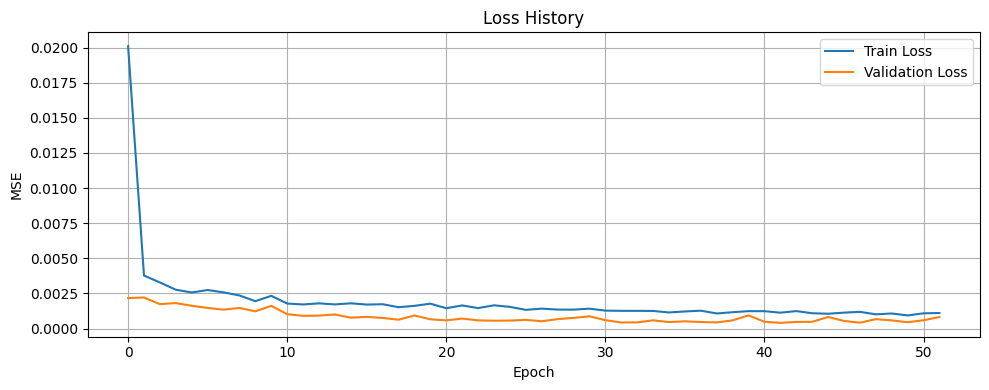

In [10]:
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss History')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Evaluasi MAE & RMSE

In [11]:
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"MAE  : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step
MAE  : 0.0145
RMSE : 0.0200


Visualisasi Hasil Prediksi vs Aktual

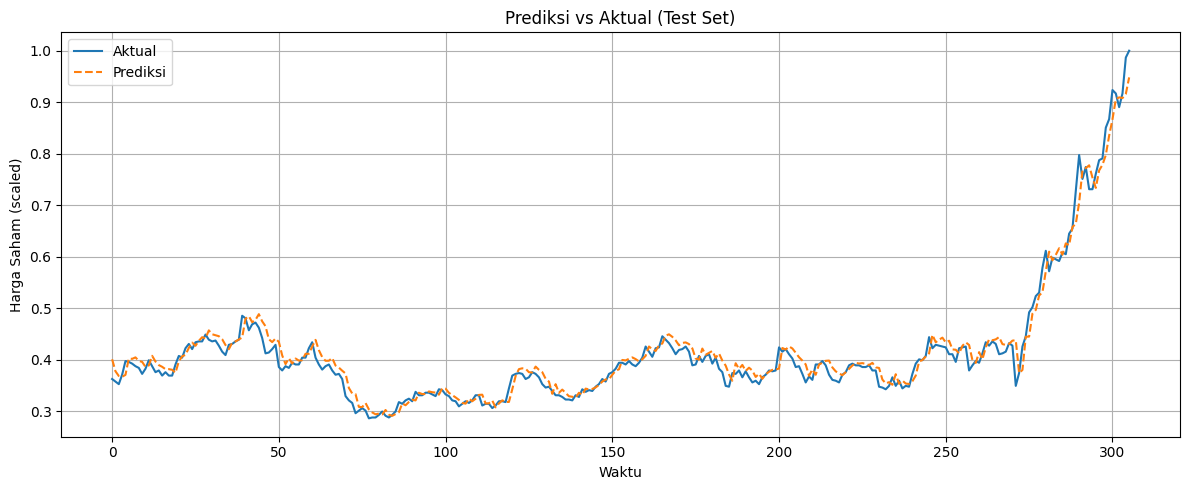

In [12]:
plt.figure(figsize=(12,5))
plt.plot(y_test, label='Aktual')
plt.plot(y_pred, label='Prediksi', linestyle='--')
plt.title('Prediksi vs Aktual (Test Set)')
plt.xlabel('Waktu')
plt.ylabel('Harga Saham (scaled)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Simpan Hasil Evaluasi ke File

In [13]:
eval_df = pd.DataFrame({
    'MAE': [mae],
    'RMSE': [rmse]
})
eval_df.to_csv('results/reports/evaluation_clstm.csv', index=False)
print("📊 Hasil evaluasi disimpan di: results/reports/evaluation_clstm.csv")

📊 Hasil evaluasi disimpan di: results/reports/evaluation_clstm.csv
